In [6]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [7]:
# Establish Database Connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established successfully!")
except Exception as e:
    print(f"❌ Connection error: {e}")

# Helper function for statistical analysis
def print_descriptive_stats(data, title):
    """Print comprehensive descriptive statistics"""
    print(f"\n📊 {title}")
    print("=" * 60)
    print(f"Count: {len(data):,}")
    print(f"Mean: {data.mean():.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Mode: {data.mode().iloc[0] if len(data.mode()) > 0 else 'N/A'}")
    print(f"Standard Deviation: {data.std():.2f}")
    print(f"Min: {data.min()}")
    print(f"Max: {data.max()}")
    print(f"Q25: {data.quantile(0.25):.2f}")
    print(f"Q75: {data.quantile(0.75):.2f}")
    print(f"IQR: {data.quantile(0.75) - data.quantile(0.25):.2f}")

print("📚 Helper functions defined successfully!")

✅ Database connection established successfully!
📚 Helper functions defined successfully!


# Score Progression Analysis
Analyzing how scores develop throughout matches and identifying patterns in score progression

In [8]:
# Query score progression data
score_progression_query = """
SELECT 
    r.id_demo_exports,
    r.round_num,
    r.t1_score_end as t1_rounds_won,
    r.t2_score_end as t2_rounds_won,
    r.t1_score_end + r.t2_score_end as total_rounds_played,
    CASE 
        WHEN r.team1_winner = true THEN 1
        WHEN r.team1_winner = false THEN 2
        ELSE NULL
    END as winner_team_id,
    -- Calculate round-by-round score differences
    r.t1_score_end - r.t2_score_end as score_difference,
    -- Identify which team is leading
    CASE 
        WHEN r.t1_score_end > r.t2_score_end THEN 1
        WHEN r.t2_score_end > r.t1_score_end THEN 2
        ELSE 0
    END as leading_team
FROM rounds_ed r
WHERE r.round_num IS NOT NULL
ORDER BY r.id_demo_exports, r.round_num
"""

print("🔍 Querying score progression data...")
score_df = pd.read_sql(score_progression_query, conn)
print(f"📊 Retrieved {len(score_df):,} round records from {score_df['id_demo_exports'].nunique():,} matches")

# Preview the data
print("\n🔍 Score progression data preview:")
print(score_df.head(10))
print(f"\nData shape: {score_df.shape}")
print(f"Unique matches: {score_df['id_demo_exports'].nunique():,}")

🔍 Querying score progression data...


C:\Users\peter\AppData\Local\Temp\ipykernel_15280\2303257855.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  score_df = pd.read_sql(score_progression_query, conn)


📊 Retrieved 2,601,592 round records from 98,937 matches

🔍 Score progression data preview:
   id_demo_exports  round_num  t1_rounds_won  t2_rounds_won  \
0                1          1              0              1   
1                1          2              1              1   
2                1          3              2              1   
3                1          4              3              1   
4                1          5              4              1   
5                1          6              5              1   
6                1          7              5              2   
7                1          8              5              3   
8                1          9              5              4   
9                1         10              6              4   

   total_rounds_played  winner_team_id  score_difference  leading_team  
0                    1               2                -1             2  
1                    2               1                 0             

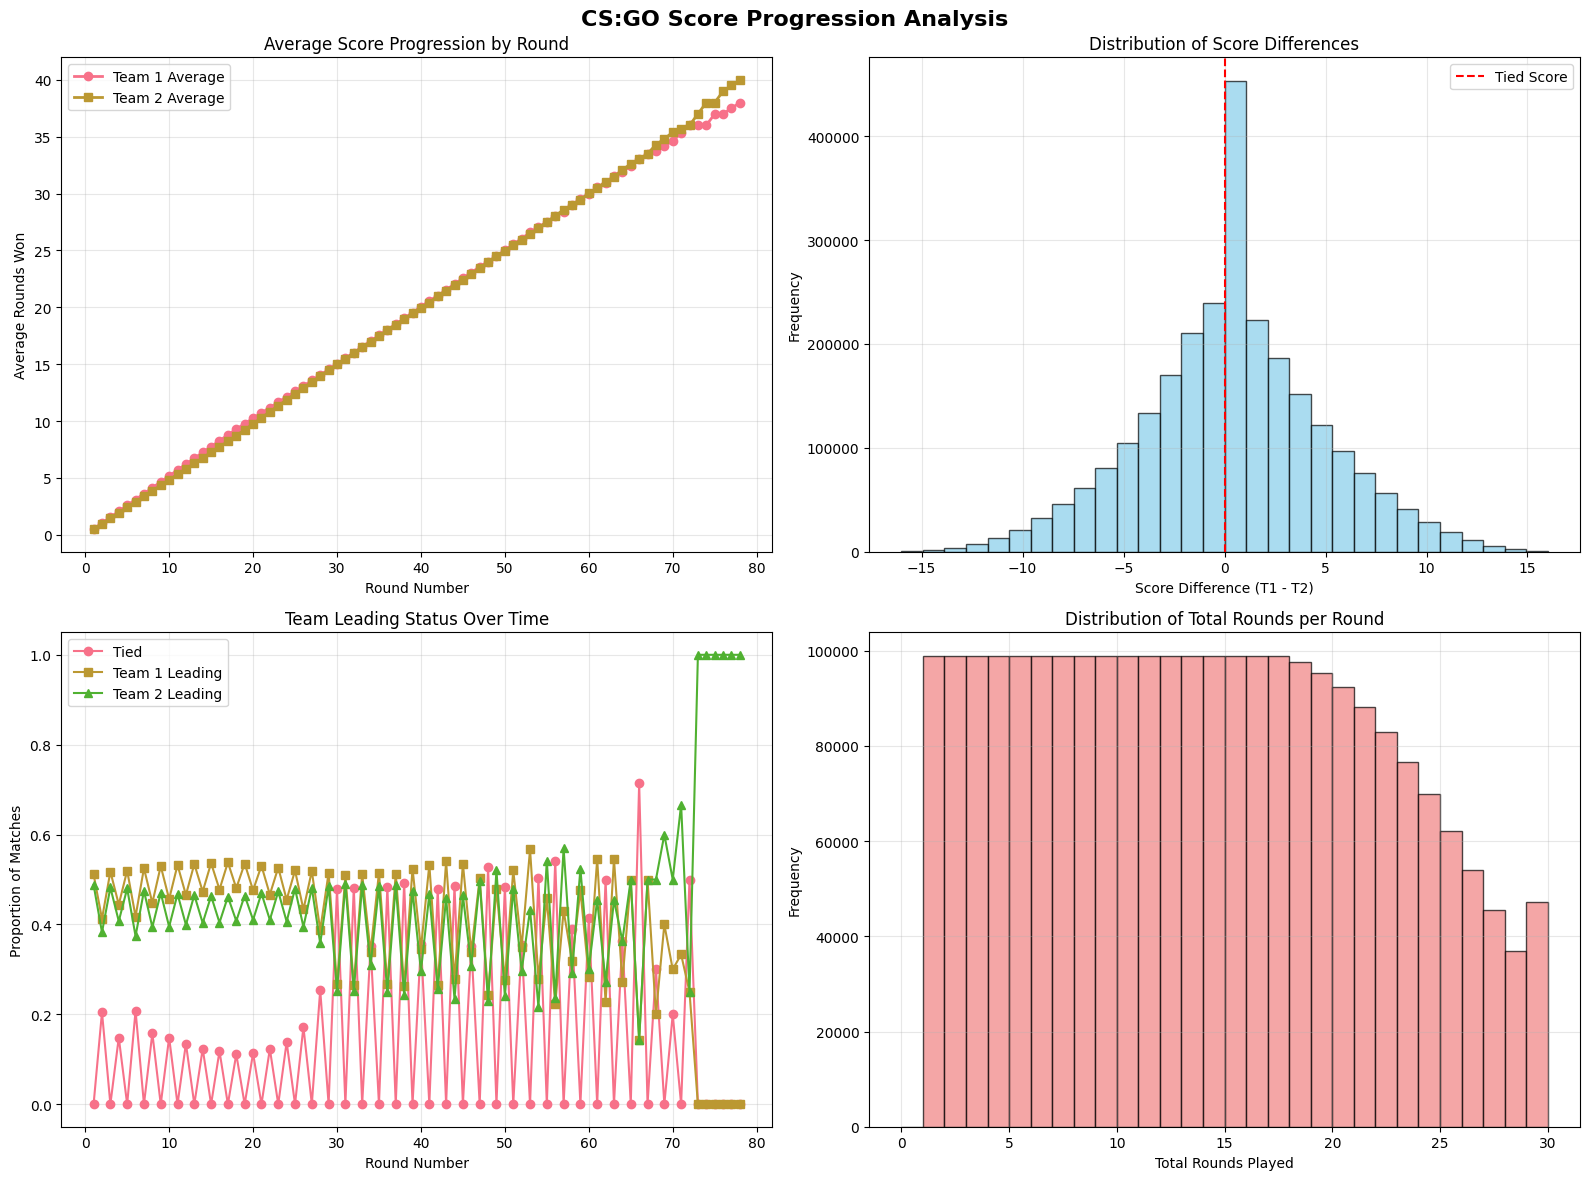


📊 SCORE PROGRESSION STATISTICS
Average rounds per match point: 14.1
Most rounds in a single match state: 78
Average score difference: 3.65
Maximum score difference: 16


In [9]:
# Create comprehensive score progression visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('CS:GO Score Progression Analysis', fontsize=16, fontweight='bold')

# 1. Average score progression over rounds
round_stats = score_df.groupby('round_num').agg({
    't1_rounds_won': 'mean',
    't2_rounds_won': 'mean',
    'total_rounds_played': 'mean'
}).reset_index()

axes[0,0].plot(round_stats['round_num'], round_stats['t1_rounds_won'], 
               label='Team 1 Average', marker='o', linewidth=2)
axes[0,0].plot(round_stats['round_num'], round_stats['t2_rounds_won'], 
               label='Team 2 Average', marker='s', linewidth=2)
axes[0,0].set_xlabel('Round Number')
axes[0,0].set_ylabel('Average Rounds Won')
axes[0,0].set_title('Average Score Progression by Round')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Score difference distribution
axes[0,1].hist(score_df['score_difference'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(0, color='red', linestyle='--', label='Tied Score')
axes[0,1].set_xlabel('Score Difference (T1 - T2)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Score Differences')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Leading team over time
leading_team_stats = score_df.groupby('round_num')['leading_team'].value_counts(normalize=True).unstack(fill_value=0)
if 0 in leading_team_stats.columns:
    axes[1,0].plot(leading_team_stats.index, leading_team_stats[0], label='Tied', marker='o')
if 1 in leading_team_stats.columns:
    axes[1,0].plot(leading_team_stats.index, leading_team_stats[1], label='Team 1 Leading', marker='s')
if 2 in leading_team_stats.columns:
    axes[1,0].plot(leading_team_stats.index, leading_team_stats[2], label='Team 2 Leading', marker='^')
axes[1,0].set_xlabel('Round Number')
axes[1,0].set_ylabel('Proportion of Matches')
axes[1,0].set_title('Team Leading Status Over Time')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Total rounds played distribution
axes[1,1].hist(score_df['total_rounds_played'], bins=range(0, 31), alpha=0.7, 
               color='lightcoral', edgecolor='black')
axes[1,1].set_xlabel('Total Rounds Played')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Total Rounds per Round')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print basic score progression statistics
print("\n📊 SCORE PROGRESSION STATISTICS")
print("=" * 60)
print(f"Average rounds per match point: {score_df['total_rounds_played'].mean():.1f}")
print(f"Most rounds in a single match state: {score_df['total_rounds_played'].max()}")
print(f"Average score difference: {abs(score_df['score_difference']).mean():.2f}")
print(f"Maximum score difference: {abs(score_df['score_difference']).max()}")

# Final Match Scores Analysis
Analyzing the final scores of completed matches and understanding score distributions

In [10]:
# Query final match scores
final_scores_query = """
WITH match_final_scores AS (
    SELECT 
        id_demo_exports,
        MAX(t1_score_end) as t1_final_score,
        MAX(t2_score_end) as t2_final_score,
        MAX(t1_score_end) + MAX(t2_score_end) as total_rounds,
        MAX(round_num) as max_round_num,
        MAX(CASE 
            WHEN team1_winner = true THEN 1
            WHEN team1_winner = false THEN 2
            ELSE NULL
        END) as final_winner
    FROM rounds_ed 
    WHERE round_num IS NOT NULL
    GROUP BY id_demo_exports
)
SELECT 
    *,
    ABS(t1_final_score - t2_final_score) as score_margin,
    CASE 
        WHEN t1_final_score > t2_final_score THEN t1_final_score 
        ELSE t2_final_score 
    END as winner_score,
    CASE 
        WHEN t1_final_score < t2_final_score THEN t1_final_score 
        ELSE t2_final_score 
    END as loser_score,
    CASE
        WHEN ABS(t1_final_score - t2_final_score) <= 3 THEN 'Close (0-3 rounds)'
        WHEN ABS(t1_final_score - t2_final_score) <= 6 THEN 'Moderate (4-6 rounds)'
        ELSE 'Dominant (7+ rounds)'
    END as match_type
FROM match_final_scores
WHERE t1_final_score IS NOT NULL AND t2_final_score IS NOT NULL
"""

print("🏁 Querying final match scores...")
final_scores_df = pd.read_sql(final_scores_query, conn)
print(f"📊 Retrieved {len(final_scores_df):,} completed matches")

# Print descriptive statistics for final scores
print_descriptive_stats(final_scores_df['winner_score'], "WINNER SCORES")
print_descriptive_stats(final_scores_df['loser_score'], "LOSER SCORES")
print_descriptive_stats(final_scores_df['score_margin'], "SCORE MARGINS")
print_descriptive_stats(final_scores_df['total_rounds'], "TOTAL ROUNDS PER MATCH")

# Match type distribution
print(f"\n🎯 MATCH TYPE DISTRIBUTION")
print("=" * 40)
match_type_counts = final_scores_df['match_type'].value_counts()
for match_type, count in match_type_counts.items():
    percentage = (count / len(final_scores_df)) * 100
    print(f"{match_type}: {count:,} ({percentage:.1f}%)")

🏁 Querying final match scores...


C:\Users\peter\AppData\Local\Temp\ipykernel_15280\164480591.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  final_scores_df = pd.read_sql(final_scores_query, conn)


📊 Retrieved 98,937 completed matches

📊 WINNER SCORES
Count: 98,937
Mean: 16.39
Median: 16.00
Mode: 16
Standard Deviation: 1.42
Min: 15
Max: 40
Q25: 16.00
Q75: 16.00
IQR: 0.00

📊 LOSER SCORES
Count: 98,937
Mean: 9.90
Median: 10.00
Mode: 14
Standard Deviation: 4.18
Min: 0
Max: 38
Q25: 7.00
Q75: 13.00
IQR: 6.00

📊 SCORE MARGINS
Count: 98,937
Mean: 6.49
Median: 6.00
Mode: 2
Standard Deviation: 3.54
Min: 0
Max: 16
Q25: 3.00
Q75: 9.00
IQR: 6.00

📊 TOTAL ROUNDS PER MATCH
Count: 98,937
Mean: 26.30
Median: 26.00
Mode: 30
Standard Deviation: 5.14
Min: 16
Max: 78
Q25: 23.00
Q75: 29.00
IQR: 6.00

🎯 MATCH TYPE DISTRIBUTION
Dominant (7+ rounds): 44,907 (45.4%)
Moderate (4-6 rounds): 27,874 (28.2%)
Close (0-3 rounds): 26,156 (26.4%)


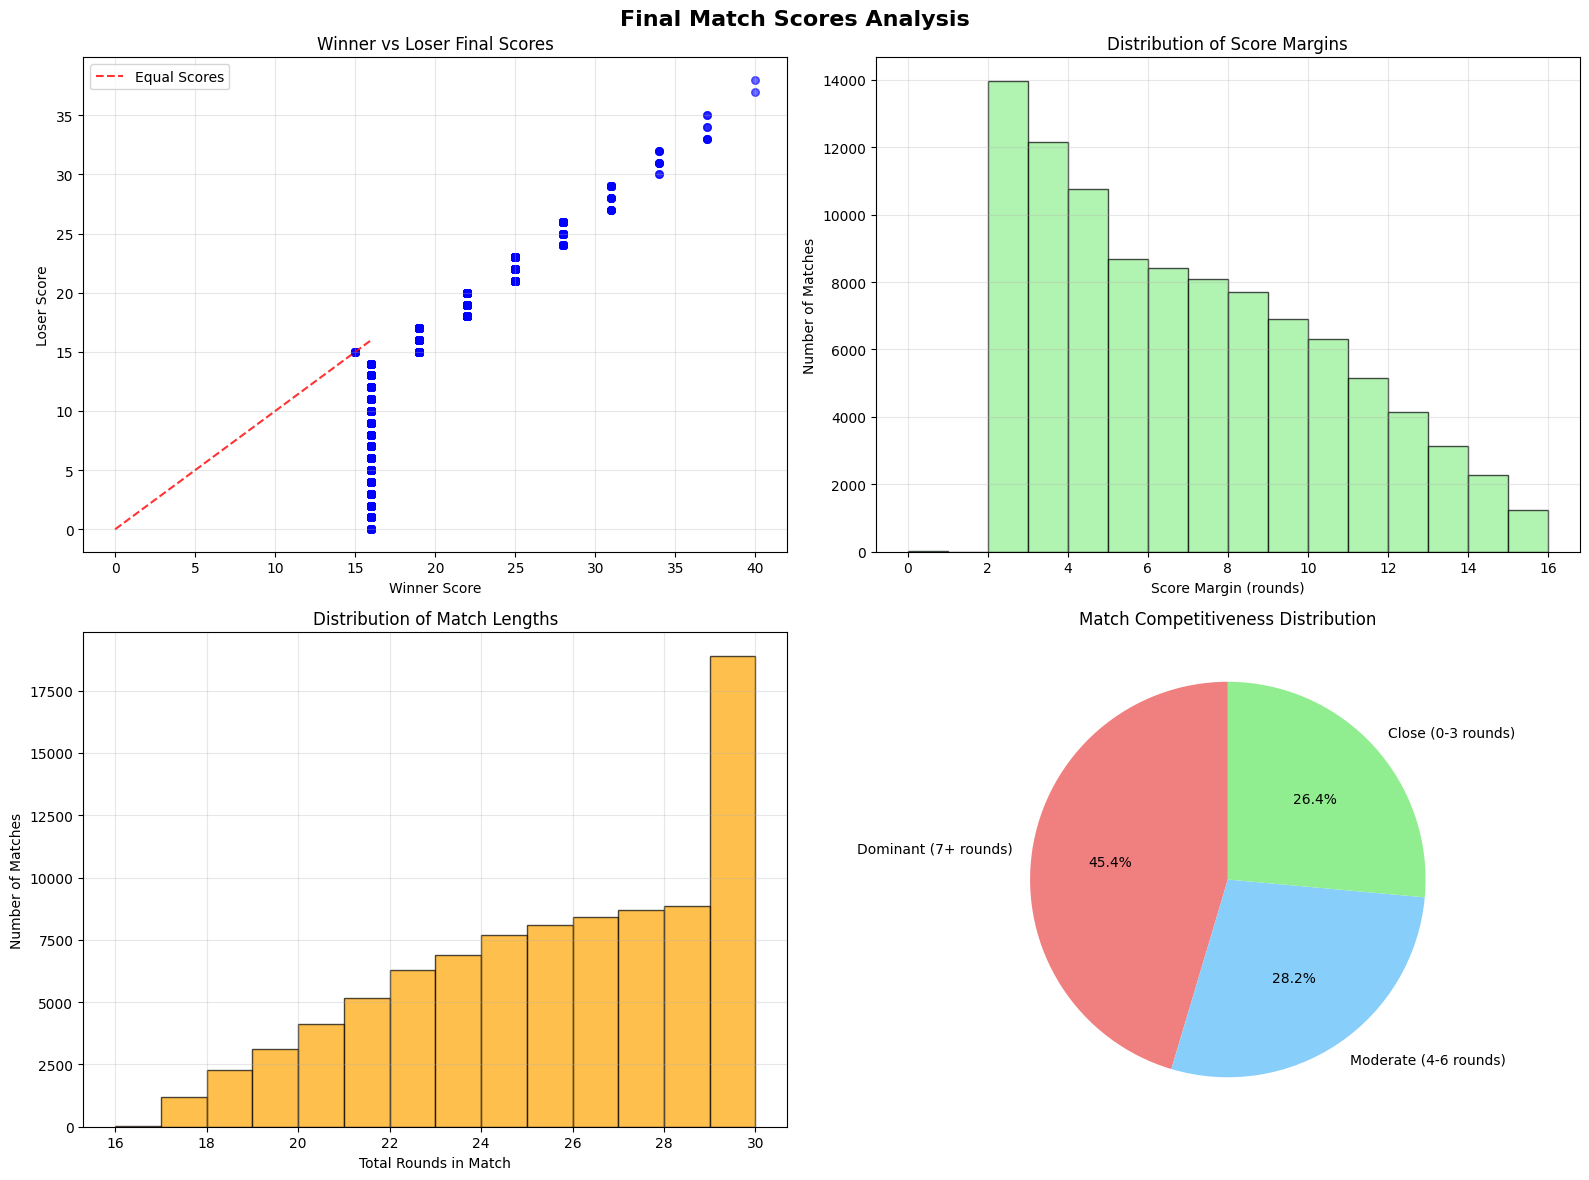


🏆 MOST COMMON FINAL SCORES
16-14: 9,952 matches (10.1%)
16-13: 8,917 matches (9.0%)
16-12: 8,874 matches (9.0%)
16-11: 8,692 matches (8.8%)
16-10: 8,411 matches (8.5%)
16-9: 8,101 matches (8.2%)
16-8: 7,693 matches (7.8%)
16-7: 6,890 matches (7.0%)
16-6: 6,305 matches (6.4%)
16-5: 5,167 matches (5.2%)
16-14: 9,952 matches (10.1%)
16-13: 8,917 matches (9.0%)
16-12: 8,874 matches (9.0%)
16-11: 8,692 matches (8.8%)
16-10: 8,411 matches (8.5%)
16-9: 8,101 matches (8.2%)
16-8: 7,693 matches (7.8%)
16-7: 6,890 matches (7.0%)
16-6: 6,305 matches (6.4%)
16-5: 5,167 matches (5.2%)


In [11]:
# Visualize final score distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Final Match Scores Analysis', fontsize=16, fontweight='bold')

# 1. Winner vs Loser scores scatter plot
axes[0,0].scatter(final_scores_df['winner_score'], final_scores_df['loser_score'], 
                  alpha=0.6, c='blue', s=30)
axes[0,0].plot([0, 16], [0, 16], 'r--', alpha=0.8, label='Equal Scores')
axes[0,0].set_xlabel('Winner Score')
axes[0,0].set_ylabel('Loser Score')
axes[0,0].set_title('Winner vs Loser Final Scores')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Score margin distribution
axes[0,1].hist(final_scores_df['score_margin'], bins=range(0, 17), alpha=0.7, 
               color='lightgreen', edgecolor='black')
axes[0,1].set_xlabel('Score Margin (rounds)')
axes[0,1].set_ylabel('Number of Matches')
axes[0,1].set_title('Distribution of Score Margins')
axes[0,1].grid(True, alpha=0.3)

# 3. Total rounds distribution
axes[1,0].hist(final_scores_df['total_rounds'], bins=range(16, 31), alpha=0.7, 
               color='orange', edgecolor='black')
axes[1,0].set_xlabel('Total Rounds in Match')
axes[1,0].set_ylabel('Number of Matches')
axes[1,0].set_title('Distribution of Match Lengths')
axes[1,0].grid(True, alpha=0.3)

# 4. Match type pie chart
match_type_counts = final_scores_df['match_type'].value_counts()
colors = ['lightcoral', 'lightskyblue', 'lightgreen']
axes[1,1].pie(match_type_counts.values, labels=match_type_counts.index, autopct='%1.1f%%',
              colors=colors, startangle=90)
axes[1,1].set_title('Match Competitiveness Distribution')

plt.tight_layout()
plt.show()

# Common final scores analysis
print(f"\n🏆 MOST COMMON FINAL SCORES")
print("=" * 50)
score_combinations = final_scores_df[['winner_score', 'loser_score']].apply(
    lambda x: f"{max(x)}-{min(x)}", axis=1
).value_counts().head(10)

for score, count in score_combinations.items():
    percentage = (count / len(final_scores_df)) * 100
    print(f"{score}: {count:,} matches ({percentage:.1f}%)")

# Winning Streaks Analysis
Analyzing how long winning streaks typically last and patterns in consecutive wins

In [12]:
# Query winning streaks data
winning_streaks_query = """
WITH round_winners AS (
    SELECT 
        id_demo_exports,
        round_num,
        CASE 
            WHEN team1_winner = true THEN 1
            WHEN team1_winner = false THEN 2
            ELSE NULL
        END as winner_team_id,
        LAG(CASE 
            WHEN team1_winner = true THEN 1
            WHEN team1_winner = false THEN 2
            ELSE NULL
        END) OVER (PARTITION BY id_demo_exports ORDER BY round_num) as prev_winner
    FROM rounds_ed 
    WHERE team1_winner IS NOT NULL 
    ORDER BY id_demo_exports, round_num
),
streak_starts AS (
    SELECT 
        *,
        CASE 
            WHEN prev_winner IS NULL OR prev_winner != winner_team_id THEN 1 
            ELSE 0 
        END as is_streak_start
    FROM round_winners
),
streak_groups AS (
    SELECT 
        *,
        SUM(is_streak_start) OVER (PARTITION BY id_demo_exports ORDER BY round_num) as streak_group
    FROM streak_starts
),
streaks AS (
    SELECT 
        id_demo_exports,
        winner_team_id,
        streak_group,
        COUNT(*) as streak_length,
        MIN(round_num) as streak_start_round,
        MAX(round_num) as streak_end_round
    FROM streak_groups
    GROUP BY id_demo_exports, winner_team_id, streak_group
)
SELECT * FROM streaks
WHERE streak_length >= 1
ORDER BY streak_length DESC
"""

print("🔥 Querying winning streaks data...")
streaks_df = pd.read_sql(winning_streaks_query, conn)
print(f"📊 Found {len(streaks_df):,} winning streaks across all matches")

# Calculate streak statistics
print_descriptive_stats(streaks_df['streak_length'], "WINNING STREAK LENGTHS")

# Streak length distribution
print(f"\n🔥 WINNING STREAK LENGTH DISTRIBUTION")
print("=" * 50)
streak_counts = streaks_df['streak_length'].value_counts().sort_index()
for length, count in streak_counts.head(10).items():
    percentage = (count / len(streaks_df)) * 100
    print(f"{length} rounds: {count:,} streaks ({percentage:.1f}%)")

# Longest streaks
print(f"\n🏆 LONGEST WINNING STREAKS")
print("=" * 40)
longest_streaks = streaks_df.nlargest(10, 'streak_length')
for idx, streak in longest_streaks.iterrows():
    print(f"Match {streak['id_demo_exports']}: {streak['streak_length']} rounds "
          f"(Team {streak['winner_team_id']}, rounds {streak['streak_start_round']}-{streak['streak_end_round']})")

🔥 Querying winning streaks data...


C:\Users\peter\AppData\Local\Temp\ipykernel_15280\81910383.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  streaks_df = pd.read_sql(winning_streaks_query, conn)


📊 Found 965,181 winning streaks across all matches

📊 WINNING STREAK LENGTHS
Count: 965,181
Mean: 2.70
Median: 2.00
Mode: 1
Standard Deviation: 2.07
Min: 1
Max: 16
Q25: 1.00
Q75: 4.00
IQR: 3.00

🔥 WINNING STREAK LENGTH DISTRIBUTION
1 rounds: 376,689 streaks (39.0%)
2 rounds: 176,136 streaks (18.2%)
3 rounds: 166,100 streaks (17.2%)
4 rounds: 87,499 streaks (9.1%)
5 rounds: 66,775 streaks (6.9%)
6 rounds: 35,512 streaks (3.7%)
7 rounds: 22,726 streaks (2.4%)
8 rounds: 13,377 streaks (1.4%)
9 rounds: 8,248 streaks (0.9%)
10 rounds: 4,921 streaks (0.5%)

🏆 LONGEST WINNING STREAKS
Match 58325: 16 rounds (Team 1, rounds 6-21)
Match 60383: 16 rounds (Team 1, rounds 2-17)
Match 94833: 16 rounds (Team 1, rounds 3-18)
Match 116771: 16 rounds (Team 2, rounds 4-19)
Match 136017: 16 rounds (Team 1, rounds 5-20)
Match 9385: 16 rounds (Team 1, rounds 3-18)
Match 73950: 16 rounds (Team 2, rounds 3-18)
Match 116223: 16 rounds (Team 2, rounds 4-19)
Match 70456: 16 rounds (Team 1, rounds 5-20)
Match 105

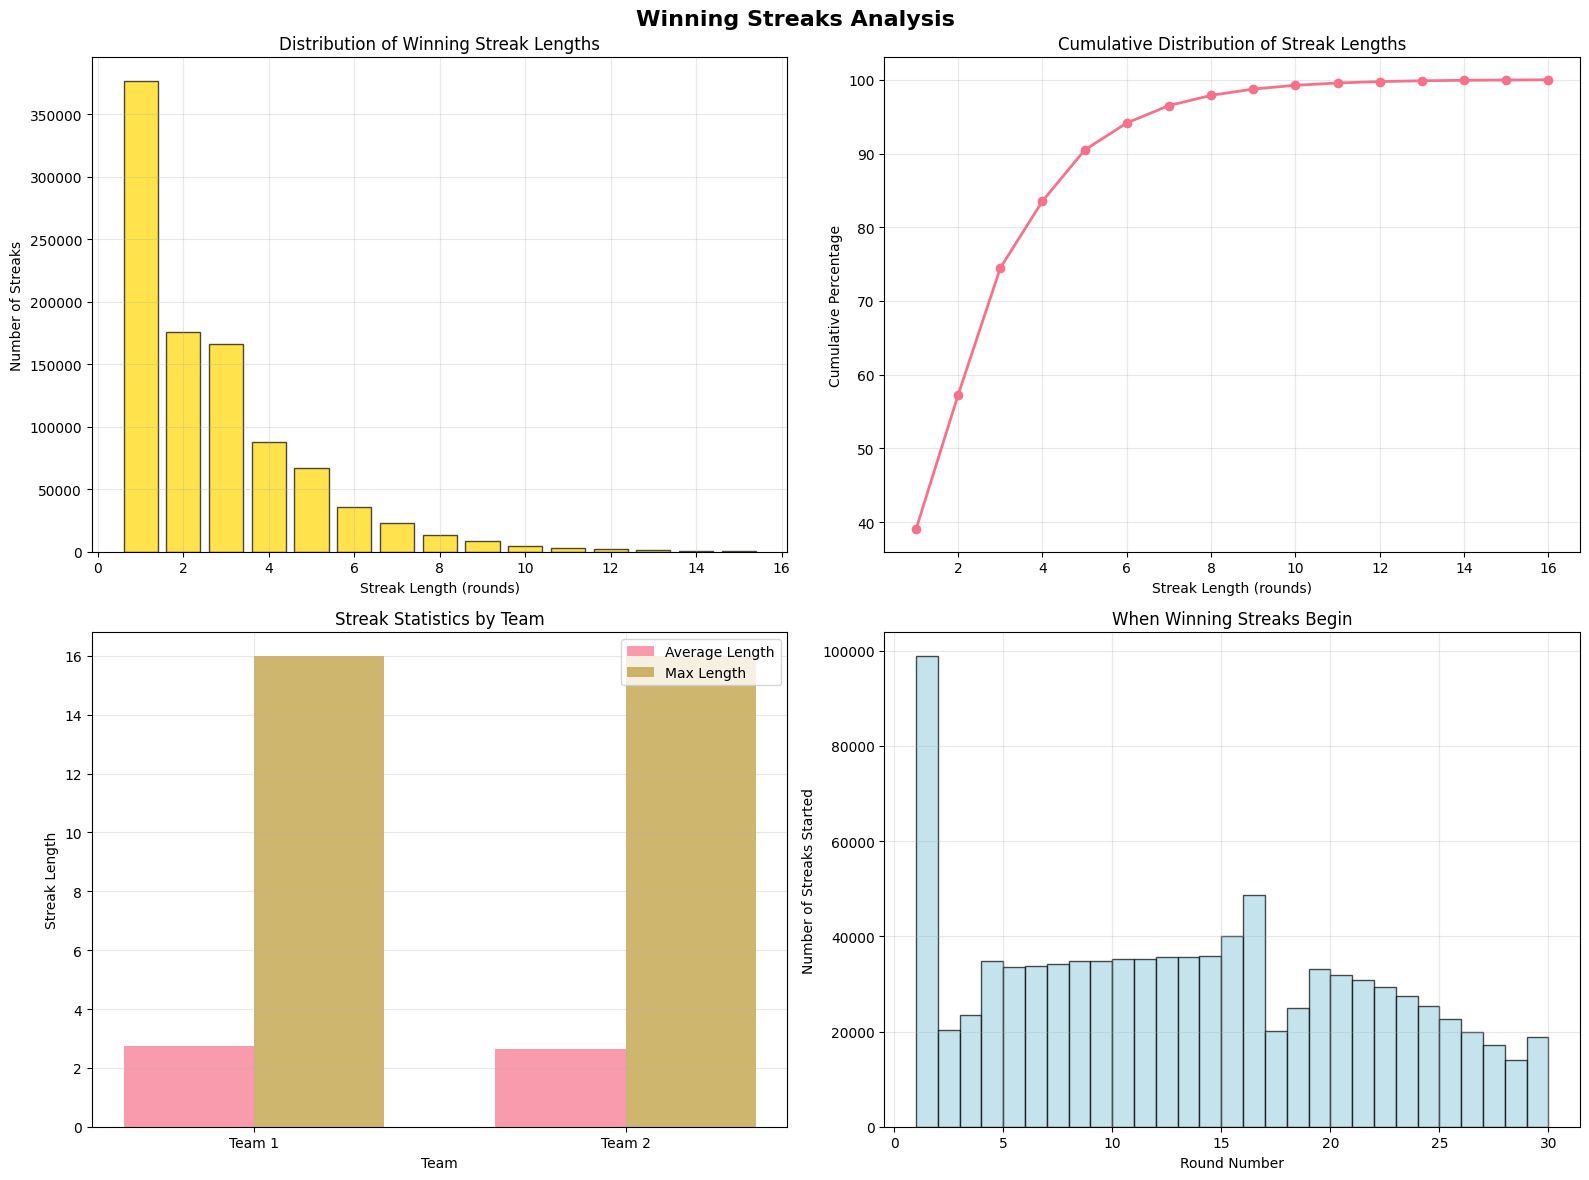


🎯 STREAK PATTERN ANALYSIS
Short streaks (1-2 rounds): 552,825 (57.3%)
Medium streaks (3-5 rounds): 320,374 (33.2%)
Long streaks (6+ rounds): 91,982 (9.5%)

Most common streak length: 1 rounds
Average streak length: 2.7 rounds
Median streak length: 2.0 rounds


In [13]:
# Visualize winning streaks
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Winning Streaks Analysis', fontsize=16, fontweight='bold')

# 1. Streak length distribution
streak_counts = streaks_df['streak_length'].value_counts().sort_index()
axes[0,0].bar(streak_counts.index[:15], streak_counts.values[:15], 
              color='gold', edgecolor='black', alpha=0.7)
axes[0,0].set_xlabel('Streak Length (rounds)')
axes[0,0].set_ylabel('Number of Streaks')
axes[0,0].set_title('Distribution of Winning Streak Lengths')
axes[0,0].grid(True, alpha=0.3)

# 2. Cumulative distribution of streak lengths
cumulative_pct = (streak_counts.sort_index().cumsum() / len(streaks_df) * 100)
axes[0,1].plot(cumulative_pct.index, cumulative_pct.values, marker='o', linewidth=2)
axes[0,1].set_xlabel('Streak Length (rounds)')
axes[0,1].set_ylabel('Cumulative Percentage')
axes[0,1].set_title('Cumulative Distribution of Streak Lengths')
axes[0,1].grid(True, alpha=0.3)

# 3. Streak lengths by team
team_streaks = streaks_df.groupby('winner_team_id')['streak_length'].agg(['count', 'mean', 'max']).round(2)
team_labels = [f'Team {int(team)}' for team in team_streaks.index]
x_pos = np.arange(len(team_labels))
width = 0.35

axes[1,0].bar(x_pos - width/2, team_streaks['mean'], width, label='Average Length', alpha=0.7)
axes[1,0].bar(x_pos + width/2, team_streaks['max'], width, label='Max Length', alpha=0.7)
axes[1,0].set_xlabel('Team')
axes[1,0].set_ylabel('Streak Length')
axes[1,0].set_title('Streak Statistics by Team')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels(team_labels)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Streak start positions in matches
axes[1,1].hist(streaks_df['streak_start_round'], bins=range(1, 31), 
               alpha=0.7, color='lightblue', edgecolor='black')
axes[1,1].set_xlabel('Round Number')
axes[1,1].set_ylabel('Number of Streaks Started')
axes[1,1].set_title('When Winning Streaks Begin')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze streak patterns
print(f"\n🎯 STREAK PATTERN ANALYSIS")
print("=" * 50)

# Short vs Long streaks
short_streaks = len(streaks_df[streaks_df['streak_length'] <= 2])
medium_streaks = len(streaks_df[(streaks_df['streak_length'] >= 3) & (streaks_df['streak_length'] <= 5)])
long_streaks = len(streaks_df[streaks_df['streak_length'] >= 6])

print(f"Short streaks (1-2 rounds): {short_streaks:,} ({short_streaks/len(streaks_df)*100:.1f}%)")
print(f"Medium streaks (3-5 rounds): {medium_streaks:,} ({medium_streaks/len(streaks_df)*100:.1f}%)")
print(f"Long streaks (6+ rounds): {long_streaks:,} ({long_streaks/len(streaks_df)*100:.1f}%)")

# Most common streak length
most_common_length = streaks_df['streak_length'].mode().iloc[0]
print(f"\nMost common streak length: {most_common_length} rounds")
print(f"Average streak length: {streaks_df['streak_length'].mean():.1f} rounds")
print(f"Median streak length: {streaks_df['streak_length'].median():.1f} rounds")

# Additional Interesting Statistics
Exploring momentum shifts, comeback patterns, and other fascinating match dynamics

In [14]:
# Analyze momentum and comeback patterns
momentum_query = """
WITH round_by_round AS (
    SELECT 
        id_demo_exports,
        round_num,
        CASE 
            WHEN team1_winner = true THEN 1
            WHEN team1_winner = false THEN 2
            ELSE NULL
        END as winner_team_id,
        t1_score_end as t1_rounds_won,
        t2_score_end as t2_rounds_won,
        t1_score_end - t2_score_end as score_diff,
        LAG(t1_score_end - t2_score_end) OVER (PARTITION BY id_demo_exports ORDER BY round_num) as prev_score_diff
    FROM rounds_ed 
    WHERE team1_winner IS NOT NULL
    ORDER BY id_demo_exports, round_num
),
momentum_shifts AS (
    SELECT 
        *,
        CASE 
            WHEN score_diff > 0 AND prev_score_diff <= 0 THEN 'T1_gained_lead'
            WHEN score_diff < 0 AND prev_score_diff >= 0 THEN 'T2_gained_lead'
            WHEN score_diff = 0 AND prev_score_diff != 0 THEN 'Tied_up'
            ELSE 'No_shift'
        END as momentum_shift,
        ABS(score_diff - prev_score_diff) as score_change
    FROM round_by_round
    WHERE prev_score_diff IS NOT NULL
)
SELECT * FROM momentum_shifts
WHERE momentum_shift != 'No_shift'
"""

print("⚡ Analyzing momentum shifts and comebacks...")
momentum_df = pd.read_sql(momentum_query, conn)
print(f"📊 Found {len(momentum_df):,} momentum shifts")

# Count different types of momentum shifts
momentum_types = momentum_df['momentum_shift'].value_counts()
print(f"\n⚡ MOMENTUM SHIFT TYPES")
print("=" * 40)
for shift_type, count in momentum_types.items():
    percentage = (count / len(momentum_df)) * 100
    print(f"{shift_type.replace('_', ' ')}: {count:,} ({percentage:.1f}%)")

# Analyze score changes during momentum shifts
print_descriptive_stats(momentum_df['score_change'], "SCORE CHANGES DURING MOMENTUM SHIFTS")

⚡ Analyzing momentum shifts and comebacks...


C:\Users\peter\AppData\Local\Temp\ipykernel_15280\3136164382.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  momentum_df = pd.read_sql(momentum_query, conn)


📊 Found 413,594 momentum shifts

⚡ MOMENTUM SHIFT TYPES
Tied up: 206,810 (50.0%)
T1 gained lead: 105,794 (25.6%)
T2 gained lead: 100,990 (24.4%)

📊 SCORE CHANGES DURING MOMENTUM SHIFTS
Count: 413,594
Mean: 1.00
Median: 1.00
Mode: 1
Standard Deviation: 0.00
Min: 1
Max: 1
Q25: 1.00
Q75: 1.00
IQR: 0.00


In [15]:
# Analyze match competitiveness and early leads
competitiveness_query = """
WITH match_analysis AS (
    SELECT 
        id_demo_exports,
        -- Score at important intervals
        MAX(CASE WHEN round_num = 5 THEN ABS(t1_score_end - t2_score_end) END) as score_diff_round_5,
        MAX(CASE WHEN round_num = 10 THEN ABS(t1_score_end - t2_score_end) END) as score_diff_round_10,
        MAX(CASE WHEN round_num = 15 THEN ABS(t1_score_end - t2_score_end) END) as score_diff_round_15,
        -- Final score difference
        MAX(ABS(t1_score_end - t2_score_end)) as final_score_diff,
        -- Match length
        MAX(t1_score_end + t2_score_end) as total_rounds,
        -- Early leader (team leading after round 5)
        MAX(CASE WHEN round_num = 5 AND t1_score_end > t2_score_end THEN 1
                 WHEN round_num = 5 AND t2_score_end > t1_score_end THEN 2
                 ELSE 0 END) as early_leader,
        -- Final winner
        MAX(CASE WHEN t1_score_end > t2_score_end THEN 1 ELSE 2 END) as final_winner
    FROM rounds_ed
    WHERE team1_winner IS NOT NULL
    GROUP BY id_demo_exports
    HAVING MAX(t1_score_end + t2_score_end) >= 16  -- Only completed matches
)
SELECT 
    *,
    CASE WHEN early_leader = final_winner THEN 1 ELSE 0 END as early_leader_won,
    CASE 
        WHEN total_rounds <= 19 THEN 'Short (16-19 rounds)'
        WHEN total_rounds <= 25 THEN 'Medium (20-25 rounds)'
        ELSE 'Long (26+ rounds)'
    END as match_length_category
FROM match_analysis
WHERE early_leader != 0  -- Exclude ties after round 5
"""

print("🎯 Analyzing match competitiveness and early leads...")
comp_df = pd.read_sql(competitiveness_query, conn)
print(f"📊 Analyzed {len(comp_df):,} matches with clear early leaders")

# Early leader success rate
early_leader_success = comp_df['early_leader_won'].mean()
print(f"\n👑 EARLY LEADER SUCCESS RATE")
print("=" * 40)
print(f"Matches where early leader won: {comp_df['early_leader_won'].sum():,}")
print(f"Total matches analyzed: {len(comp_df):,}")
print(f"Success rate: {early_leader_success:.1%}")

# Score progression correlation
print(f"\n📈 SCORE PROGRESSION CORRELATIONS")
print("=" * 50)
correlations = comp_df[['score_diff_round_5', 'score_diff_round_10', 
                       'score_diff_round_15', 'final_score_diff']].corr()
print("Round 5 vs Final:", f"{correlations.loc['score_diff_round_5', 'final_score_diff']:.3f}")
print("Round 10 vs Final:", f"{correlations.loc['score_diff_round_10', 'final_score_diff']:.3f}")
print("Round 15 vs Final:", f"{correlations.loc['score_diff_round_15', 'final_score_diff']:.3f}")

# Match length analysis
print(f"\n⏱️ MATCH LENGTH ANALYSIS")
print("=" * 30)
length_analysis = comp_df.groupby('match_length_category').agg({
    'early_leader_won': ['count', 'mean'],
    'final_score_diff': 'mean'
}).round(3)
print(length_analysis)

🎯 Analyzing match competitiveness and early leads...


C:\Users\peter\AppData\Local\Temp\ipykernel_15280\3189892886.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  comp_df = pd.read_sql(competitiveness_query, conn)


📊 Analyzed 98,937 matches with clear early leaders

👑 EARLY LEADER SUCCESS RATE
Matches where early leader won: 63,818
Total matches analyzed: 98,937
Success rate: 64.5%

📈 SCORE PROGRESSION CORRELATIONS
Round 5 vs Final: 0.320
Round 10 vs Final: 0.655
Round 15 vs Final: 0.829

⏱️ MATCH LENGTH ANALYSIS
                      early_leader_won        final_score_diff
                                 count   mean             mean
match_length_category                                         
Long (26+ rounds)                54030  0.564            6.220
Medium (20-25 rounds)            38291  0.718            9.632
Short (16-19 rounds)              6616  0.887           13.745


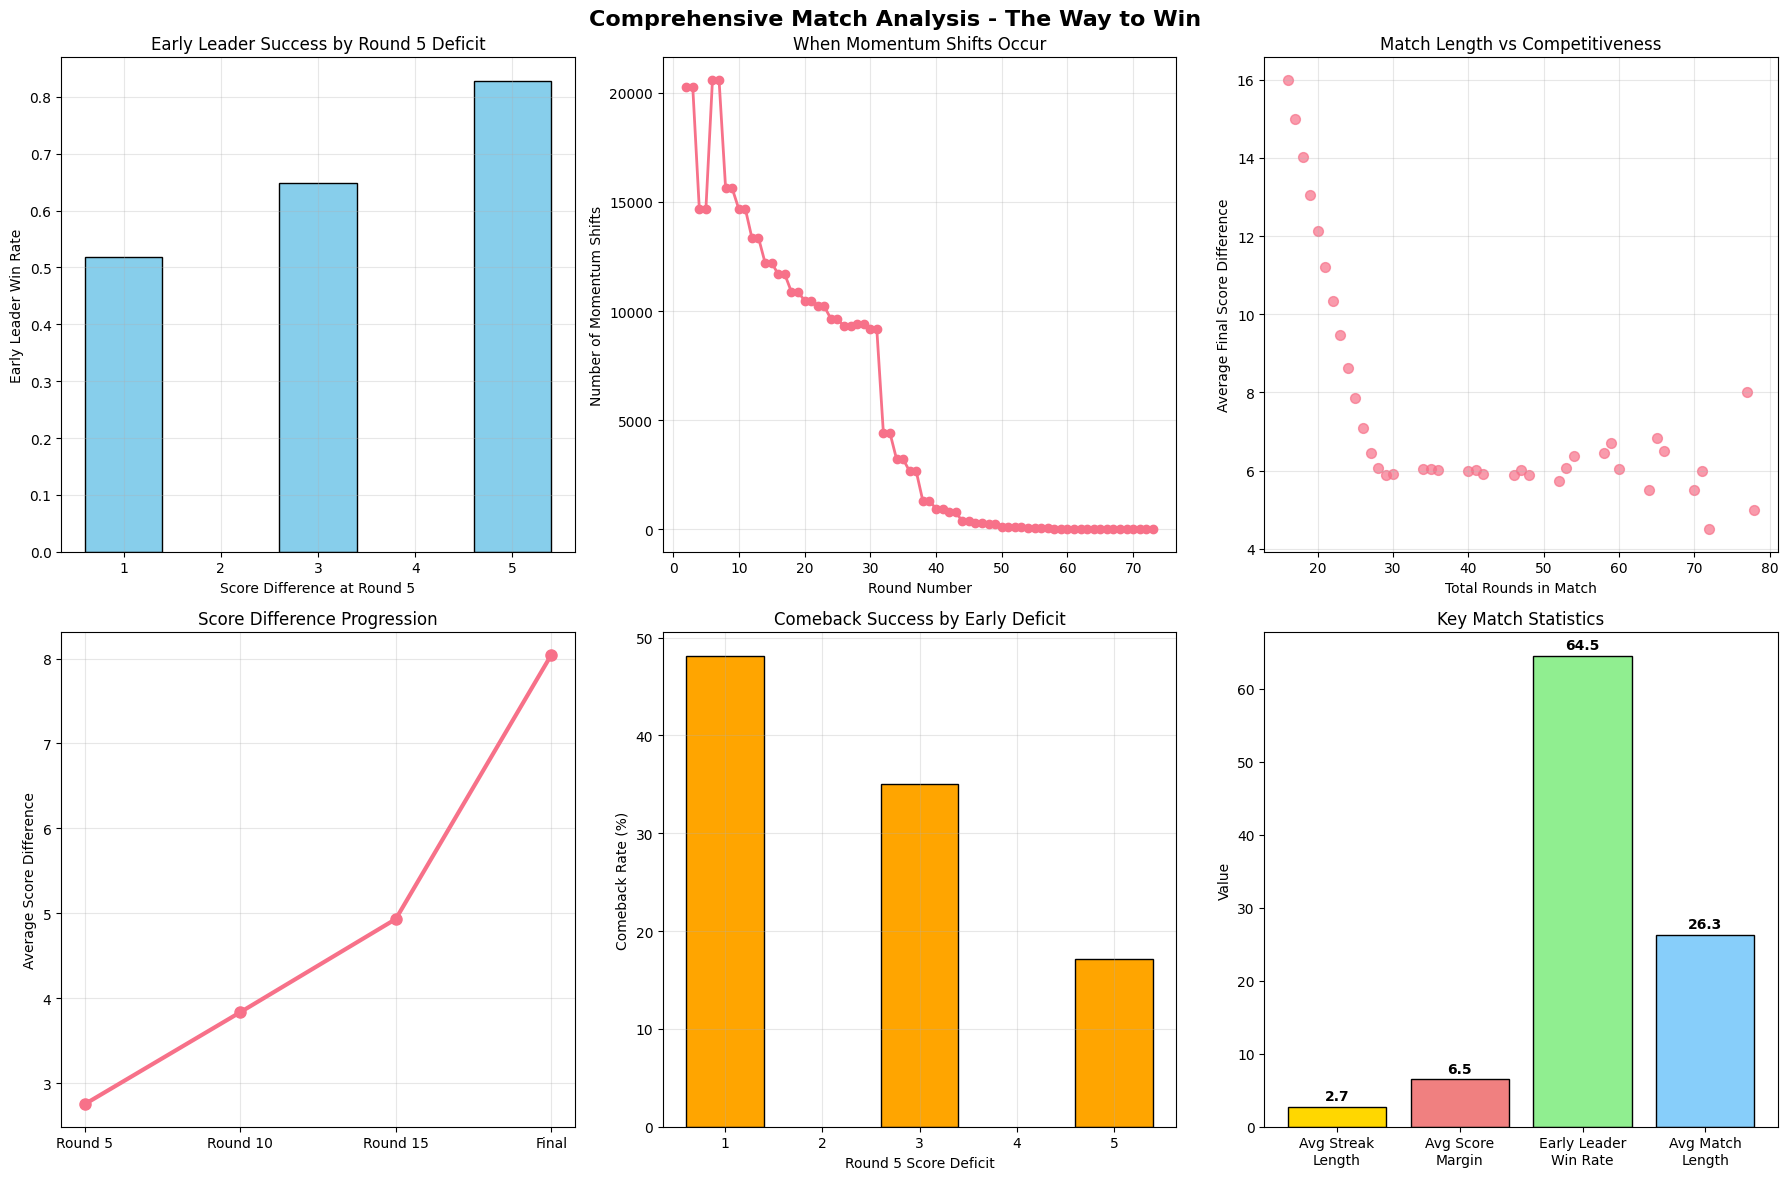


🏆 COMPREHENSIVE MATCH ANALYSIS SUMMARY
📊 Total matches analyzed: 98,937
🔥 Total winning streaks: 965,181
⚡ Momentum shifts observed: 413,594
👑 Early leader win rate: 64.5%
🎯 Average winning streak: 2.7 rounds
📈 Most common final score: 16-14
⏱️ Average match length: 26.3 rounds
🏁 Closest average margin: 6.5 rounds


In [16]:
# Create comprehensive final visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Match Analysis - The Way to Win', fontsize=16, fontweight='bold')

# 1. Early leader success by round difference
round5_groups = comp_df.groupby('score_diff_round_5')['early_leader_won'].mean()
axes[0,0].bar(round5_groups.index, round5_groups.values, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Score Difference at Round 5')
axes[0,0].set_ylabel('Early Leader Win Rate')
axes[0,0].set_title('Early Leader Success by Round 5 Deficit')
axes[0,0].grid(True, alpha=0.3)

# 2. Momentum shift timing
momentum_timing = momentum_df.groupby('round_num').size()
axes[0,1].plot(momentum_timing.index, momentum_timing.values, marker='o', linewidth=2)
axes[0,1].set_xlabel('Round Number')
axes[0,1].set_ylabel('Number of Momentum Shifts')
axes[0,1].set_title('When Momentum Shifts Occur')
axes[0,1].grid(True, alpha=0.3)

# 3. Match length vs competitiveness
length_comp = comp_df.groupby('total_rounds')['final_score_diff'].mean()
axes[0,2].scatter(length_comp.index, length_comp.values, alpha=0.7, s=50)
axes[0,2].set_xlabel('Total Rounds in Match')
axes[0,2].set_ylabel('Average Final Score Difference')
axes[0,2].set_title('Match Length vs Competitiveness')
axes[0,2].grid(True, alpha=0.3)

# 4. Score progression predictability
score_progression = pd.DataFrame({
    'Round 5': comp_df['score_diff_round_5'],
    'Round 10': comp_df['score_diff_round_10'],
    'Round 15': comp_df['score_diff_round_15'],
    'Final': comp_df['final_score_diff']
})
score_progression_mean = score_progression.mean()
axes[1,0].plot(['Round 5', 'Round 10', 'Round 15', 'Final'], 
               score_progression_mean.values, marker='o', linewidth=3, markersize=8)
axes[1,0].set_ylabel('Average Score Difference')
axes[1,0].set_title('Score Difference Progression')
axes[1,0].grid(True, alpha=0.3)

# 5. Comeback frequency analysis
comeback_data = comp_df[comp_df['early_leader_won'] == 0]
comeback_by_deficit = comeback_data.groupby('score_diff_round_5').size()
total_by_deficit = comp_df.groupby('score_diff_round_5').size()
comeback_rate = (comeback_by_deficit / total_by_deficit * 100).fillna(0)

axes[1,1].bar(comeback_rate.index, comeback_rate.values, color='orange', edgecolor='black')
axes[1,1].set_xlabel('Round 5 Score Deficit')
axes[1,1].set_ylabel('Comeback Rate (%)')
axes[1,1].set_title('Comeback Success by Early Deficit')
axes[1,1].grid(True, alpha=0.3)

# 6. Overall match statistics summary
stats_labels = ['Avg Streak\nLength', 'Avg Score\nMargin', 'Early Leader\nWin Rate', 'Avg Match\nLength']
stats_values = [
    streaks_df['streak_length'].mean(),
    final_scores_df['score_margin'].mean(),
    comp_df['early_leader_won'].mean() * 100,
    final_scores_df['total_rounds'].mean()
]
colors = ['gold', 'lightcoral', 'lightgreen', 'lightskyblue']
bars = axes[1,2].bar(stats_labels, stats_values, color=colors, edgecolor='black')
axes[1,2].set_title('Key Match Statistics')
axes[1,2].set_ylabel('Value')

# Add value labels on bars
for bar, value in zip(bars, stats_values):
    height = bar.get_height()
    axes[1,2].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Final summary statistics
print(f"\n🏆 COMPREHENSIVE MATCH ANALYSIS SUMMARY")
print("=" * 60)
print(f"📊 Total matches analyzed: {final_scores_df.shape[0]:,}")
print(f"🔥 Total winning streaks: {len(streaks_df):,}")
print(f"⚡ Momentum shifts observed: {len(momentum_df):,}")
print(f"👑 Early leader win rate: {comp_df['early_leader_won'].mean():.1%}")
print(f"🎯 Average winning streak: {streaks_df['streak_length'].mean():.1f} rounds")
print(f"📈 Most common final score: {score_combinations.index[0]}")
print(f"⏱️ Average match length: {final_scores_df['total_rounds'].mean():.1f} rounds")
print(f"🏁 Closest average margin: {final_scores_df['score_margin'].mean():.1f} rounds")

In [17]:
# Close database connection
conn.close()
print("🔒 Database connection closed.")
print("✅ Complete analysis of 'The Way to Win' finished!")

🔒 Database connection closed.
✅ Complete analysis of 'The Way to Win' finished!
